<a href="https://colab.research.google.com/github/vicky-getova/FYP/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Mounting OneDrive to the notebook in order to load the dataset folder
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Extracting the folder from OneDrive to a folder in a the notebook
!cp "/content/drive/MyDrive/Colab Notebooks/FYP/ALL_IDB_data.zip" "ALL_IDB.zip"

In [22]:
# Unzipping the dataset folder in a new folder
!unzip -uq "ALL_IDB.zip" -d "ALL_IDB"

In [23]:
# Install and import all required modules and libraries 
!pip install scikeras
!pip install vit-keras
!pip install tensorflow-addons
import cv2
import re
import os
import random
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
%matplotlib inline
from vit_keras import vit, utils, visualize
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from numpy.ma.core import bitwise_and
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix


# Define all parameters used in the project
IMG_SIZE = 512                                   #  The size of the input image used in the analysis.
FIG_SIZE = 15                                    #  The size of the figures used to display the results.
WSPACE = 0.1                                     #  The width spacing used in the layout of subplots.
HSPACE = 0.1                                     #  The height spacing used in the layout of subplots.
FONTSIZE = 10                                    #  The font size used in the text labels of the figures.
NUM_IMAGES = 6                                   #  The number of random images to be displayed.
GRAY = plt.cm.Greys_r                            #  Colormap for plotting.
KERNEL_SIZE = (7, 7)                             #  The size of the kernel used in the Gaussian blur operation on the image.
SIGMA_X = 0                                      #  The standard deviation used in the Gaussian blur operation on the image.
TOP = BOTTOM = LEFT = RIGHT = 1                  #  The number of pixels used in the border of the image.
BORDER_TYPE = cv2.BORDER_CONSTANT                #  The type of border used in the padding of the image.
BORDER_VALUE = 255                               #  The value used for the padded border of the image.
SEEDPOINT  =(0,0)                                #  The starting point used in the flood fill operation.
NEWVAL = 0                                       #  The new value used in the flood fill operation.
LODIFF = 50                                      #  The lower threshold used in the flood fill operation.
UPDIFF = 50                                      #  The upper threshold used in the flood fill operation.
FLAGS = 8                                        #  The flags used in the flood fill operation.
THICKNESS = 2                                    #  The thickness of the line used in the draw contour operation.
CONTOURIDX = -1                                  #  The index of the contour used in the drawing operation.
VIT_IMG_SIZE = 224                               #  The size of the input image used in Xception model.
TEST_SIZE = 0.2                                  #  The proportion of the dataset used for testing.
TRAIN_SIZE = 0.8                                 #  The proportion of the dataset used for training.
RANDOM_STATE = 42                                #  The random state used in the splitting of the dataset.
WIDTH_SHIFT_RANGE = 0.1                          #  Randomly shift the image horizontally by up to 10% of the image width
HEIGHT_SHIFT_RANGE=0.1                           #  Randomly shift the image vertically by up to 10% of the image height.
HORIZONTAL_FLIP=True                             #  Randomly flip the image horizontally.
VERTICAL_FLIP=True                               #  Randomly flip the image vertically.
CVAL=0                                           #  The value to fill in the empty space that may appear after rotating or shifting the image
BATCH_SIZE = 8                                   #  Number of batches used during training
PATCH_SIZE = 16                                  #  The size of the patches extracted from the input image
NUM_PATCHES = (VIT_IMG_SIZE // PATCH_SIZE) ** 2  #  The total number of patches that can be extracted from the input image
LAYER_NORM_EPS = 1e-6                            #  A small value used for numerical stability while performing layer normalization.
PROJECTION_DIM = 64                              #  The size of the projection head that will be used to project the embeddings from the patch representation
CLASSES=2                                        #  Number of classed to be trained by the model
PRETRAINED='True'                                #  The model is initialized with pre-trained weights
INCLUDE_TOP = 'False'                            #  The final fully-connected classification layer is excluded from the model
PRETRAINED_TOP = 'False'                         #  The pre-trained weights for the final classification layer are not used
PATIENCE=5                                       #  Number of epochs to wait before reducing the learning rate when the metric plateaus
VERBOSE=2                                        #  The verbosity mode
FACTOR=0.5                                       #  Factor by which the learning rate will be reduced
MIN_LR=0.00001                                   #  Learning rate will not be reduced below this value
LEARNING_RATE = 0.001                            #  Learning Rate of the optimizer
LOSS ='categorical_crossentropy'                 #  Loss function when compiling the model
EPOCHS=15                                        #  The number of times to iterate through the entire training dataset
PERCENT = 100                                    #  Used in the calculation of the percentage for evaluation metrics.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
# Loading an image from the ALL_IDB1 file using cv2.imread() funnction.
image_color = cv2.imread('/content/drive/MyDrive/Colab Notebooks/FYP/ALL_IDB/ALL_IDB2/ALL_IDB2/img/Im001_1.tif',1)

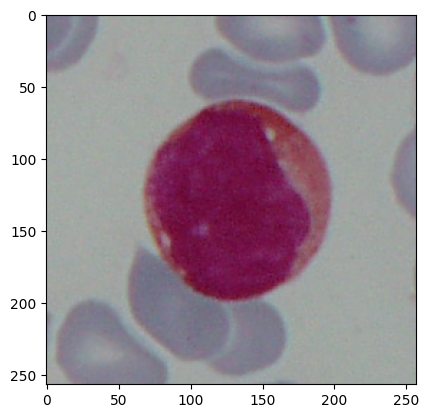

In [25]:
# Plot test data as an image from the dataset uing imshow() function .
plt.imshow(image_color)
plt.show()

In [26]:
# Return the current working directory using getcwd() method.
os.getcwd()

'/content'

In [27]:
# Get a list of all files the specified directory.
folders = os.listdir('/content/drive/MyDrive/Colab Notebooks/FYP/ALL_IDB')

# Get a list of all images the ALL_IDB1 dataset.
items_all_idb1 = os.listdir('/content/drive/MyDrive/Colab Notebooks/FYP/ALL_IDB/ALL_IDB1/ALL_IDB1/im')

# Get a list of all images the ALL_IDB2 dataset.
items_all_idb2 = os.listdir('/content/drive/MyDrive/Colab Notebooks/FYP/ALL_IDB/ALL_IDB2/ALL_IDB2/img')

print("ALL folders in the ALL_IDB Database:", folders)
print("ALL items in the ALL_IDB1 dataset:", items_all_idb1)
print("ALL items in the ALL_IDB2 dataset:", items_all_idb2)

ALL folders in the ALL_IDB Database: ['ALL_IDB1', 'ALL_IDB2']
ALL items in the ALL_IDB1 dataset: ['Im001_1.jpg', 'Im005_1.jpg', 'Im002_1.jpg', 'Im009_1.jpg', 'Im007_1.jpg', 'Im010_1.jpg', 'Im004_1.jpg', 'Im003_1.jpg', 'Im006_1.jpg', 'Im008_1.jpg', 'Im011_1.jpg', 'Im012_1.jpg', 'Im024_1.jpg', 'Im027_1.jpg', 'Im013_1.jpg', 'Im032_1.jpg', 'Im031_1.jpg', 'Im021_1.jpg', 'Im036_0.jpg', 'Im015_1.jpg', 'Im023_1.jpg', 'Im018_1.jpg', 'Im014_1.jpg', 'Im017_1.jpg', 'Im025_1.jpg', 'Im029_1.jpg', 'Im034_0.jpg', 'Im026_1.jpg', 'Im030_1.jpg', 'Im022_1.jpg', 'Im020_1.jpg', 'Im033_1.jpg', 'Im035_0.jpg', 'Im019_1.jpg', 'Im028_1.jpg', 'Im016_1.jpg', 'Im038_0.jpg', 'Im037_0.jpg', 'Im039_0.jpg', 'Im043_0.jpg', 'Im044_0.jpg', 'Im045_0.jpg', 'Im046_0.jpg', 'Im042_0.jpg', 'Im041_0.jpg', 'Im040_0.jpg', 'Im056_1.jpg', 'Im054_1.jpg', 'Im055_1.jpg', 'Im049_1.jpg', 'Im051_1.jpg', 'Im050_1.jpg', 'Im048_1.jpg', 'Im047_0.jpg', 'Im053_1.jpg', 'Im052_1.jpg', 'Im059_1.jpg', 'Im060_1.jpg', 'Im058_1.jpg', 'Im062_1.jpg', 'I

In [28]:
# Create a list of images with ALL cells of the format ImXXX_1.tif.
ALL_images = []
for image in items_all_idb2:
        if re.search('[A-Za-z0-9]+_[1]+\.[A-Za-z0-9]+', image): 
                ALL_images.append(image)
print('Number of ALL cancer images:', len(ALL_images))

# Create a list of images with healthy cells of the format ImXXX_0.tif.
healthy_images = []
for image in items_all_idb2:
        if re.search('[A-Za-z0-9]+_[0]+\.[A-Za-z0-9]+', image): 
                healthy_images.append(image)
print('Number of healthy cell images:', len(healthy_images))

Number of ALL cancer images: 130
Number of healthy cell images: 130


In [29]:
# Create two empty lists to store the resized images and their corresponding labels
ALL_list = []
ALL_labels = []

# Loop through each image file in the list of images
for each_image in ALL_images:
  # Check if the file ends with ".tif"
  if each_image.endswith(".tif"):
    # Create the full path to the image file
    full_path = "/content/drive/MyDrive/Colab Notebooks/FYP/ALL_IDB/ALL_IDB2/ALL_IDB2/img/" + each_image
    
    # Read the image from the file and resize it to the specified IMG_SIZE
    image = cv2.imread(full_path, 1)
    im_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    
    # Convert the image from BGR to RGB format
    im_converted = cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB)

    # Add the resized image to the ALL_list
    ALL_list.append(im_converted)

    # Extract the label from the full path and convert it to an integer
    label = int(full_path.split('_')[-1].split('.')[0])

    # Add the label to the ALL_labels list
    ALL_labels.append(label)

# Print the number of images and labels in the ALL_list and ALL_labels
print('Number of ALL cancer images:', len(ALL_list))
print('Number of ALL labels:', len(ALL_labels))

# Print the list of ALL_labels to confirm that the labels were extracted correctly
print('ALL labels:', ALL_labels)

# Create two empty lists to store the resized images and their corresponding labels
healthy_list = []
healthy_labels = []

# Loop through each image file in the list of healthy cell images
for each_image in healthy_images:

  # Check if the file ends with ".tif"
  if each_image.endswith(".tif"):
    # Create the full path to the image file
    full_path = "/content/drive/MyDrive/Colab Notebooks/FYP/ALL_IDB/ALL_IDB2/ALL_IDB2/img/" + each_image
    
    # Read the image from the file and resize it to the specified IMG_SIZE
    image = cv2.imread(full_path, 1)
    im_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    
    # Convert the image from BGR to RGB format
    im_converted = cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB)

    # Add the resized image to the healthy_list
    healthy_list.append(im_converted)

    # Extract the label from the full path and convert it to an integer
    label = int(full_path.split('_')[-1].split('.')[0])

    # Add the label to the healthy_labels list
    healthy_labels.append(label)

# Print the number of images and labels in the healthy_list and healthy_labels
print('Number of healthy cell images:', len(healthy_list))
print('Number of healthy labels:', len(healthy_labels))

# Print the list of healthy_labels to confirm that the labels were extracted correctly
print('Healthy labels:', healthy_labels)

Number of ALL cancer images: 130
Number of ALL labels: 130
ALL labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of healthy cell images: 130
Number of healthy labels: 130
Healthy labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


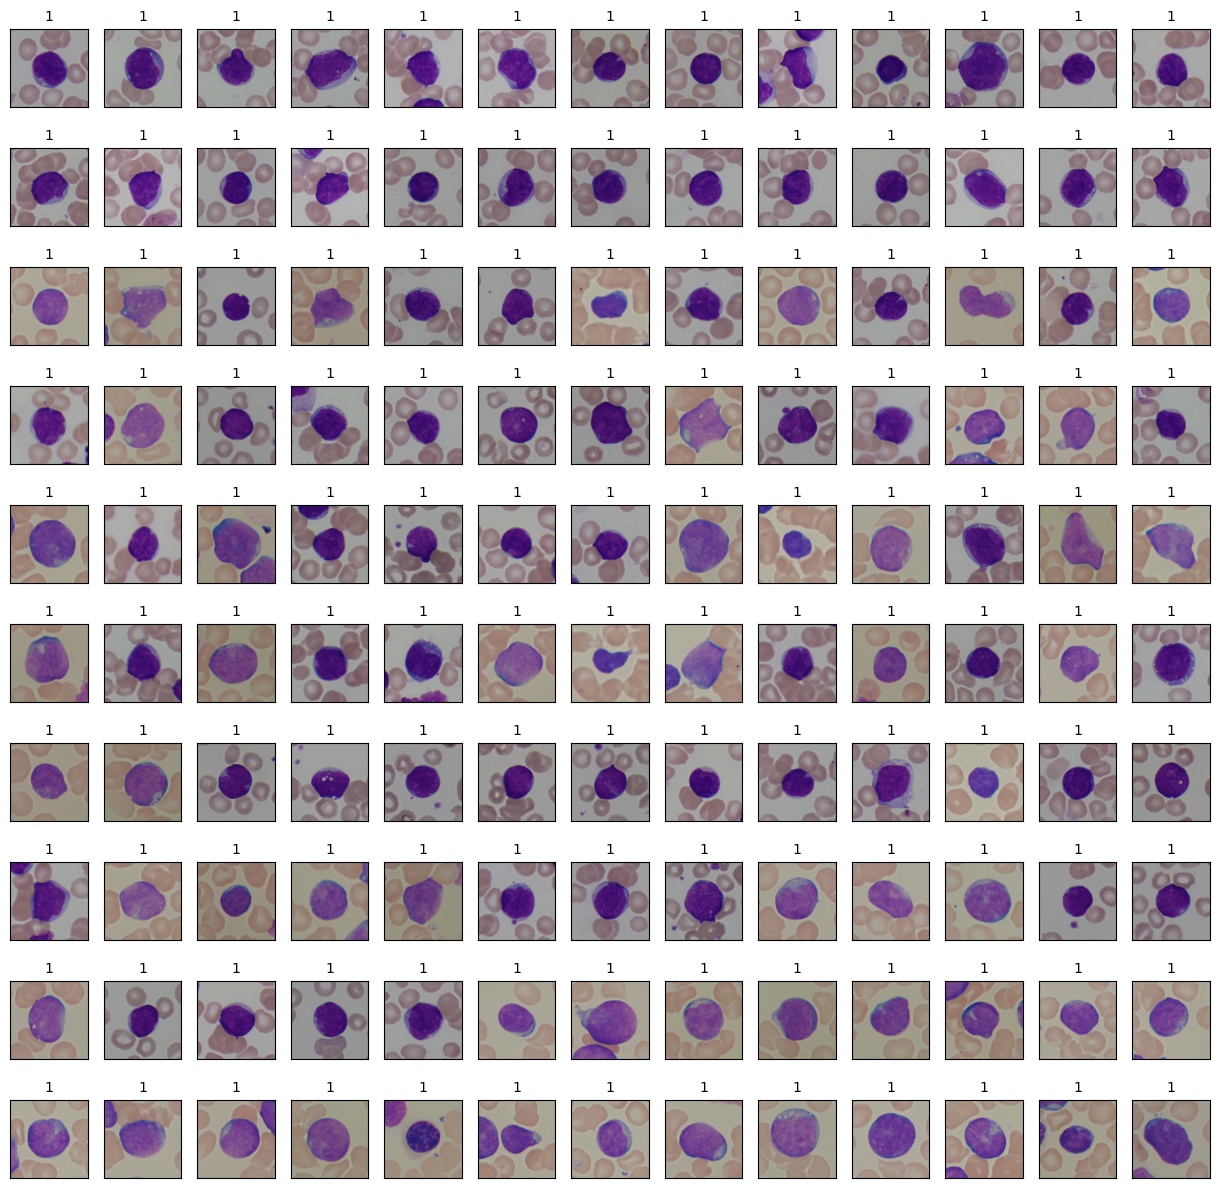

In [30]:
# Create a figure with 10 rows and 13 columns
fig, ax = plt.subplots(10, 13, figsize=(FIG_SIZE , FIG_SIZE))

# Loop through the images and their corresponding numbers
for i, (image, number) in enumerate(zip(ALL_list, ALL_labels)):
    # Calculate the row and column indices for the current image
    row = i // 13
    col = i % 13

    # Display the image on the corresponding subplot
    ax[row, col].imshow(image, cmap=GRAY)

    # Add the number as text above the image
    ax[row, col].set_title(number, fontsize=FONTSIZE)

    # Remove the ticks on the x and y axes
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

# Adjust the spacing between the subplots
plt.subplots_adjust(WSPACE, HSPACE)

# Display the figure
plt.show()

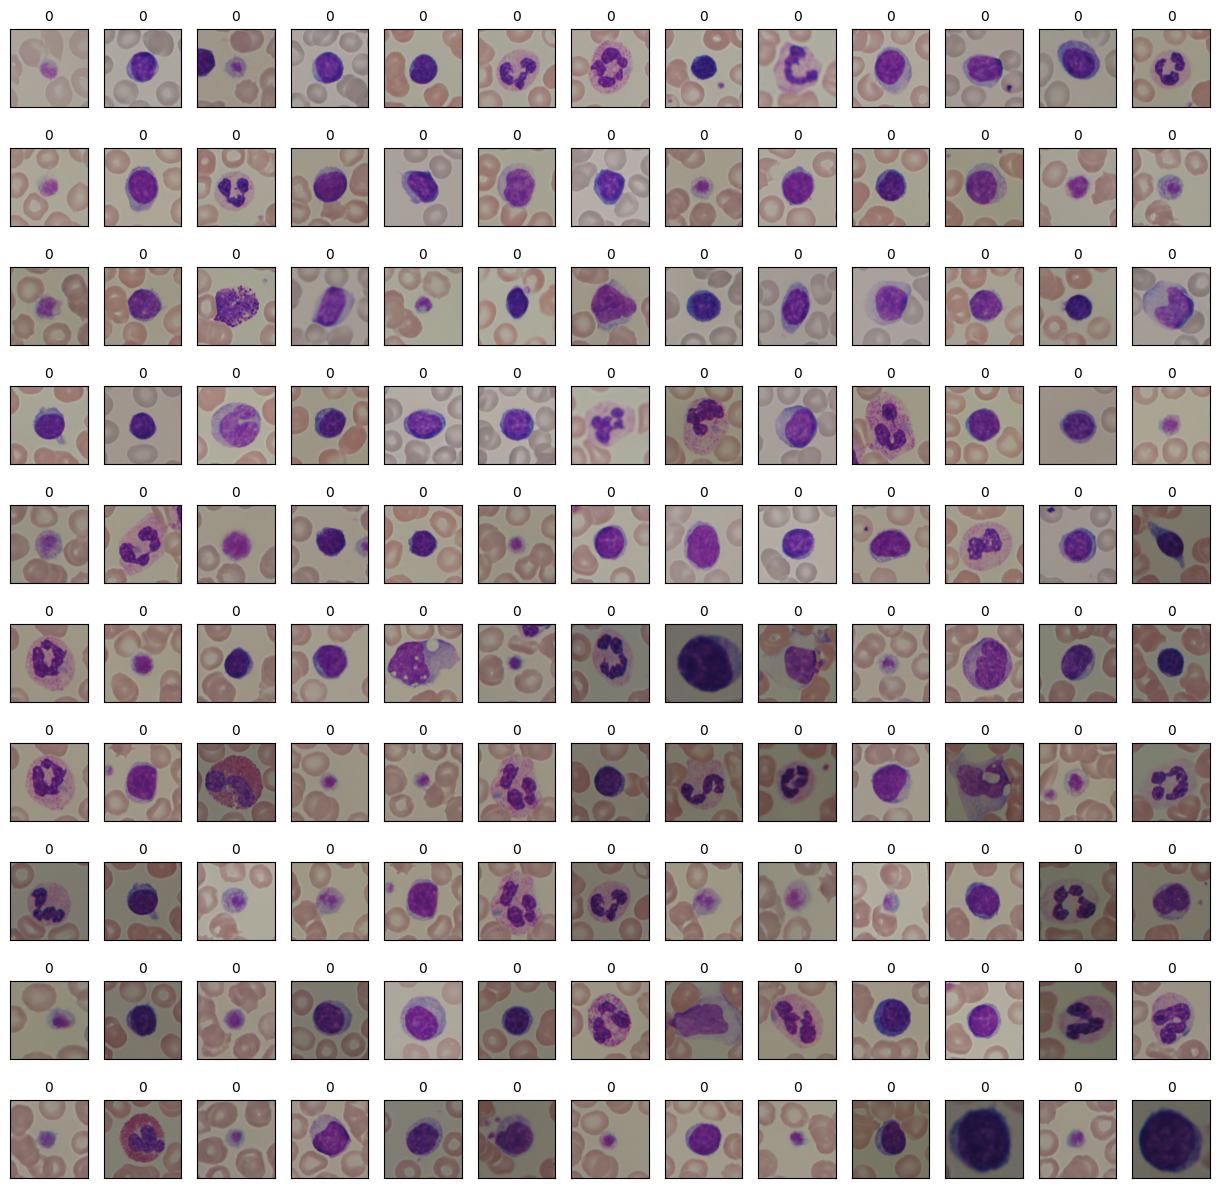

In [31]:
# Create a figure with 10 rows and 13 columns
fig, ax = plt.subplots(10, 13, figsize=(FIG_SIZE, FIG_SIZE))

# Loop through the images and their corresponding numbers
for i, (image, number) in enumerate(zip(healthy_list, healthy_labels)):
    # Calculate the row and column indices for the current image
    row = i // 13
    col = i % 13

    # Display the image on the corresponding subplot
    ax[row, col].imshow(image, cmap=GRAY)

    # Add the number as text above the image
    ax[row, col].set_title(number, fontsize=FONTSIZE)

    # Remove the ticks on the x and y axes
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

# Adjust the spacing between the subplots
plt.subplots_adjust(WSPACE, HSPACE)

# Display the figure
plt.show()

In [32]:
# Print the shape of the images in the ALL_list and healthy_list lists.
print("The Shape of the images in the ALL_list:", ALL_list[0].shape)
print("The Shape of the images in the list of healthy cells:", healthy_list[0].shape)

The Shape of the images in the ALL_list: (512, 512, 3)
The Shape of the images in the list of healthy cells: (512, 512, 3)


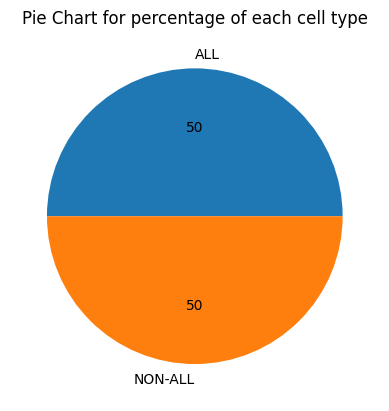

In [33]:
# Get the percentage distribution of ALL and HEM cell images.
# Create two dictionaries containing ALL and healthy cell images 
cancer_dict = {"x_col":ALL_list, "y_col":[np.nan for x in range(len(ALL_list))]}
cancer_dict["y_col"] = "ALL"

normal_dict = {"x_col":healthy_list, "y_col":[np.nan for x in range(len(healthy_list))]}
normal_dict["y_col"] = "HEALTHY"

# Convert the dictionaries to dataframes
cancer_df = pd.DataFrame(cancer_dict)
normal_df = pd.DataFrame(normal_dict)

# Plot a pie chart to show the percentage distribution of ALL and healthy cell images
plt.pie([len(ALL_list),len(healthy_list)],labels=["ALL","NON-ALL"],autopct='%.f')
plt.title('Pie Chart for percentage of each cell type')
plt.show()

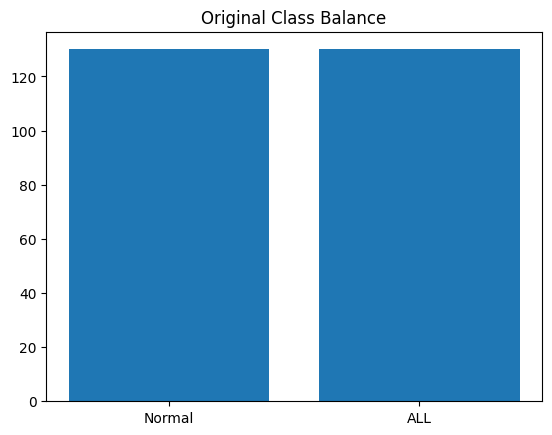

In [34]:
# Show the class balance of ALL and HEM images.
plt.bar(['Normal', 'ALL'], [len(healthy_list), len(ALL_list)])
plt.title('Original Class Balance')
plt.show()

In [35]:
# Convert the lists of images and labels to numpy arrays
ALL_list = np.array(ALL_list)
ALL_labels = np.array(ALL_labels)
print("The Shape of the ALL images numpy array:", ALL_list.shape)
print("The Shape of the ALL labels numpy array:", ALL_labels.shape)

healthy_list = np.array(healthy_list)
healthy_labels = np.array(healthy_labels)
print("The Shape of the healthy images numpy array:", healthy_list.shape)
print("The Shape of the healthy labels numpy array:", healthy_labels.shape)

The Shape of the ALL images numpy array: (130, 512, 512, 3)
The Shape of the ALL labels numpy array: (130,)
The Shape of the healthy images numpy array: (130, 512, 512, 3)
The Shape of the healthy labels numpy array: (130,)


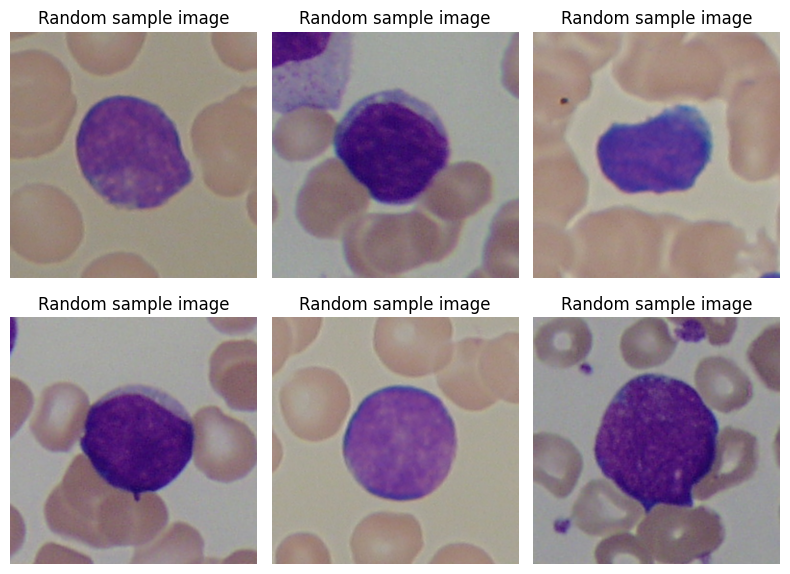

In [36]:
# Select random images from dataset
selected_images = np.random.choice(len(ALL_list), NUM_IMAGES, replace=False)

# Display selected images
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
    image = ALL_list[selected_images[i]]
    ax.imshow(image)
    ax.set_title('Random sample image')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [37]:
# # Normalize the pixel values in the cropped_images list to the range [0, 255] using cv2.normalize() function.
ALL_normalized_images = []
NON_ALL_normalized_images = []
for img in ALL_list:
    normalized_img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    ALL_normalized_images.append(normalized_img)

for img in healthy_list:
    normalized_img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    NON_ALL_normalized_images.append(normalized_img)

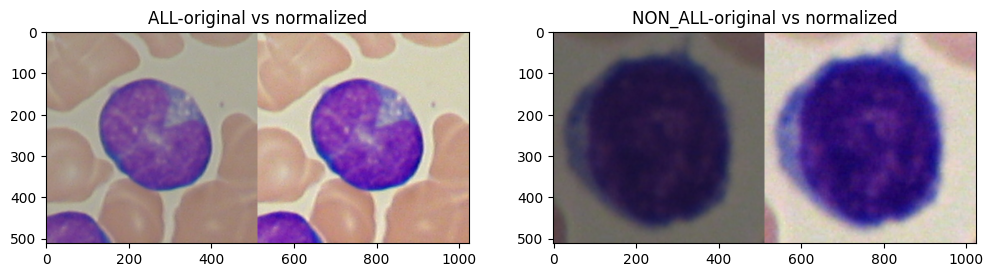

In [38]:
# Combine the original and normalised image.
combined_ALL = np.hstack((ALL_list[127], ALL_normalized_images[127]))
combined_NON_ALL = np.hstack((healthy_list[127], NON_ALL_normalized_images[127]))
# Set up the axes for plotting.  
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 14))
# This generates a single row of images with two columns and assigns them to 
# a variable `ax`.

# Plot the lightness image
ax[0].imshow(combined_ALL, cmap = GRAY)
ax[0].set_title('ALL-original vs normalized')

# Plot the a image.
ax[1].imshow(combined_NON_ALL, cmap = GRAY)
ax[1].set_title('NON_ALL-original vs normalized')
plt.show()

In [39]:
# add code for calculating the center

In [40]:
def split_channels(image):
    # Split the image into separate color channels.
    b_channel, g_channel, r_channel = cv2.split(image)

    # Print the minimum and maximum of red channel.
    print('Minimum value for red channel:', np.min(r_channel))
    print('Maximum value for red channel:', np.max(r_channel))

    # Print the minimum and maximum of green channel.
    print('Minimum value for green channel:', np.min(g_channel))
    print('Maximum value for green channel:', np.max(g_channel))

    # Print the minimum and maximum of blue channel.
    print('Minimum value for blue channel:', np.min(b_channel))
    print('Maximum value for blue channel:', np.max(b_channel))

    return r_channel, g_channel, b_channel

Minimum value for red channel: 107
Maximum value for red channel: 236
Minimum value for green channel: 0
Maximum value for green channel: 238
Minimum value for blue channel: 6
Maximum value for blue channel: 255


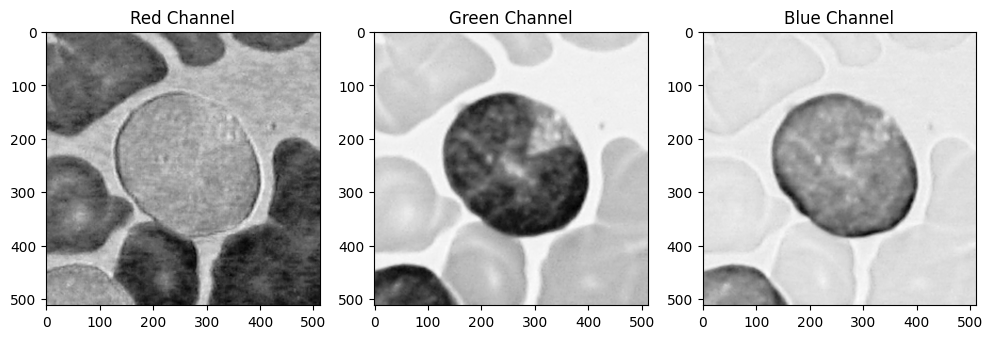

In [41]:
# This line calls a function called "split_channels" and passes in the 128th image from "ALL_normalized_images"
# The function returns the individual red, green, and blue channels of the image
r_channel, g_channel, b_channel = split_channels(ALL_normalized_images[127])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 14))
# This generates a single row of images with two columns and assigns them to 
# a variable `ax`.

# Plot the lightness image
ax[0].imshow(r_channel, cmap = GRAY)
ax[0].set_title('Red Channel')

# Plot the a image.
ax[1].imshow(g_channel, cmap = GRAY)
ax[1].set_title('Green Channel')

# Plot the a image.
ax[2].imshow(b_channel, cmap = GRAY)
ax[2].set_title('Blue Channel')
plt.show()

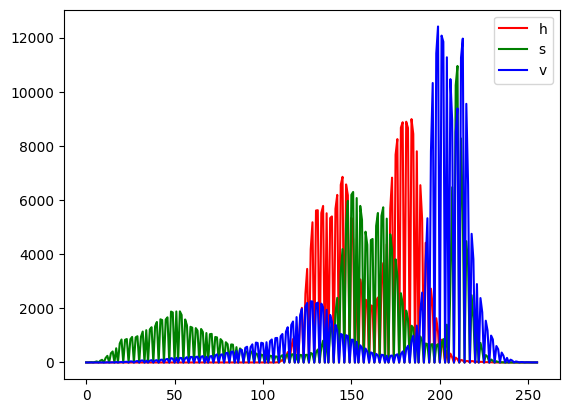

In [42]:
# Calculate the histograms of the red, green and blue channels of an image using the calcHist function from the cv2 module
hist_h = cv2.calcHist([r_channel],[0],None,[256],[0,256])
hist_s = cv2.calcHist([g_channel],[0],None,[256],[0,256])
hist_v = cv2.calcHist([b_channel],[0],None,[256],[0,256])

# Plot the three histograms on the same graph using different colors and labels
plt.plot(hist_h, color='r', label="h")
plt.plot(hist_s, color='g', label="s")
plt.plot(hist_v, color='b', label="v")

# Add a legend to the plot to show which color corresponds to each channel
plt.legend()

# Display the plot
plt.show()

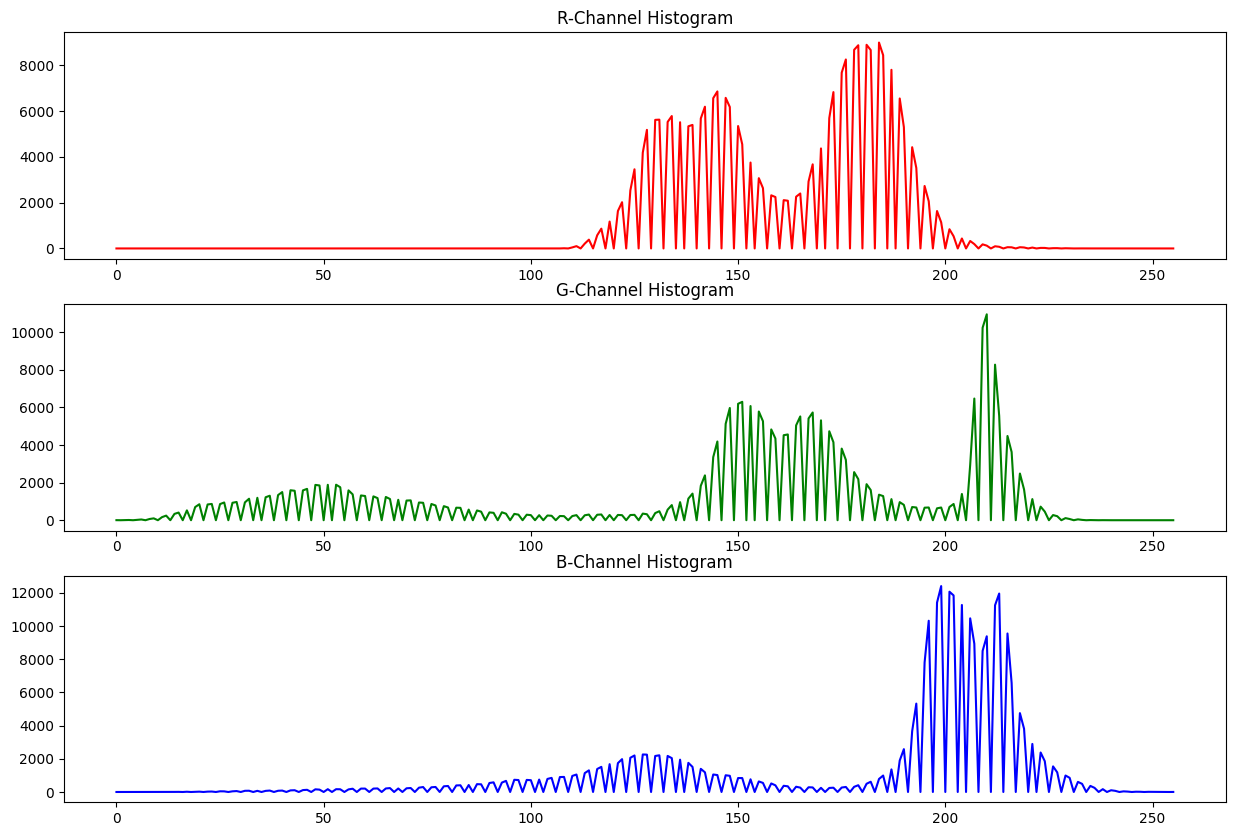

In [43]:
# Create a figure with 3 rows and 1 column, and set the size of the figure 
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
# This generates a single row of images with two columns and assigns them to 
# a variable `ax`.

# Plot the red channel histogram
ax[0].plot(hist_h, color='r')
ax[0].set_title('R-Channel Histogram')

# Plot the green channel histogram
ax[1].plot(hist_s, color='g')
ax[1].set_title('G-Channel Histogram')

# Plot the blue channel histogram
ax[2].plot(hist_v, color='b')
ax[2].set_title('B-Channel Histogram')
plt.show()

In [44]:
# Extract the green channel from all images in the normalized_images list.
# Apply Gaussian blur for smoothing to the green channels using GaussianBlur() function.
ALL_blurred_images = []
NON_ALL_blurred_images = []

for img in ALL_normalized_images:
    # Split the image into separate color channels
    b_channel, g_channel, r_channel = cv2.split(img)

    # Apply Gaussian blur to the green channel
    blurred_g_channel = cv2.GaussianBlur(g_channel, KERNEL_SIZE, SIGMA_X)

    # Add the blurred image to the list of blurred images
    ALL_blurred_images.append(blurred_g_channel)

for img in NON_ALL_normalized_images:
    # Split the image into separate color channels
    b_channel, g_channel, r_channel = cv2.split(img)

    # Apply Gaussian blur to the green channel
    blurred_g_channel = cv2.GaussianBlur(g_channel, KERNEL_SIZE, SIGMA_X)

    # Add the blurred image to the list of blurred images
    NON_ALL_blurred_images.append(blurred_g_channel)

In [45]:
# Initialize an empty list to store the threshold values
ALL_thresholds = []
NON_ALL_thresholds = []

# Loop through each image in blurred_images
for img in ALL_blurred_images:

    # Apply Otsu's thresholding
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Append the threshold value to the list
    ALL_thresholds.append(ret)

# Compute the mean threshold value
ALL_mean_threshold = np.mean(ALL_thresholds)
print("A list of all threshold values for blast images: ", ALL_thresholds)
# Print the mean threshold value
print("Mean Threshold for all blast Gaussian Blurred Green Channel images: ", ALL_mean_threshold)

# Loop through each image in blurred_images
for img in NON_ALL_blurred_images:

    # Apply Otsu's thresholding
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Append the threshold value to the list
    NON_ALL_thresholds.append(ret)

# Compute the mean threshold value
NON_ALL_mean_threshold = np.mean(NON_ALL_thresholds)
print("A list of all threshold values for healthy images: ", NON_ALL_thresholds)
# Print the mean threshold value
print("Mean Threshold for all healthy Gaussian Blurred Green Channel images: ", NON_ALL_mean_threshold)

A list of all threshold values for blast images:  [115.0, 129.0, 114.0, 121.0, 110.0, 116.0, 112.0, 110.0, 114.0, 113.0, 117.0, 113.0, 114.0, 108.0, 115.0, 111.0, 117.0, 117.0, 116.0, 121.0, 116.0, 117.0, 121.0, 121.0, 122.0, 117.0, 113.0, 131.0, 117.0, 106.0, 120.0, 118.0, 102.0, 116.0, 114.0, 115.0, 129.0, 110.0, 111.0, 124.0, 111.0, 120.0, 116.0, 116.0, 116.0, 111.0, 117.0, 121.0, 123.0, 131.0, 112.0, 118.0, 110.0, 122.0, 135.0, 109.0, 155.0, 114.0, 113.0, 114.0, 102.0, 124.0, 114.0, 114.0, 133.0, 126.0, 109.0, 117.0, 108.0, 129.0, 118.0, 107.0, 126.0, 107.0, 115.0, 114.0, 125.0, 120.0, 114.0, 103.0, 112.0, 117.0, 120.0, 110.0, 111.0, 112.0, 115.0, 115.0, 108.0, 107.0, 113.0, 112.0, 116.0, 104.0, 120.0, 111.0, 114.0, 113.0, 114.0, 122.0, 108.0, 128.0, 125.0, 115.0, 118.0, 118.0, 110.0, 119.0, 117.0, 123.0, 124.0, 123.0, 113.0, 111.0, 133.0, 114.0, 113.0, 124.0, 120.0, 117.0, 121.0, 118.0, 114.0, 116.0, 124.0, 122.0, 120.0, 115.0, 120.0, 118.0]
Mean Threshold for all blast Gaussian B

In [46]:
# Define a list to store the segmented images
ALL_segmented_images = []
NON_ALL_segmented_images = []

# Define a list to store the Canny edge images
ALL_edge_images = []
NON_ALL_edge_images = []

# Loop through each image in blurred_images
for img in ALL_blurred_images:

    # Apply the mean threshold to the image
    binary = cv2.threshold(img, ALL_mean_threshold, 255, cv2.THRESH_BINARY_INV)[1]

    # Append the segmented image to the list
    ALL_segmented_images.append(binary)

    # Find Canny edges of the thresholded image
    edges = cv2.Canny(binary, 70, 150)

    # Append the Canny edged image to the list
    ALL_edge_images.append(edges)


# Loop through each image in blurred_images
for img in NON_ALL_blurred_images:

    # Apply the mean threshold to the image
    binary = cv2.threshold(img, NON_ALL_mean_threshold, 255, cv2.THRESH_BINARY_INV)[1]

    # Append the segmented image to the list
    NON_ALL_segmented_images.append(binary)

    # Find Canny edges of the thresholded image
    edges = cv2.Canny(binary, 70, 150)

    # Append the Canny edged image to the list
    NON_ALL_edge_images.append(edges)

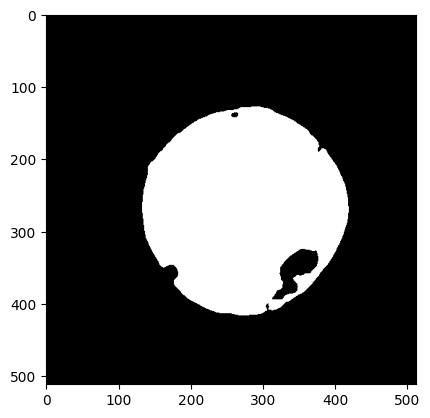

In [47]:
plt.imshow(ALL_segmented_images[79], cmap = GRAY)
plt.show()

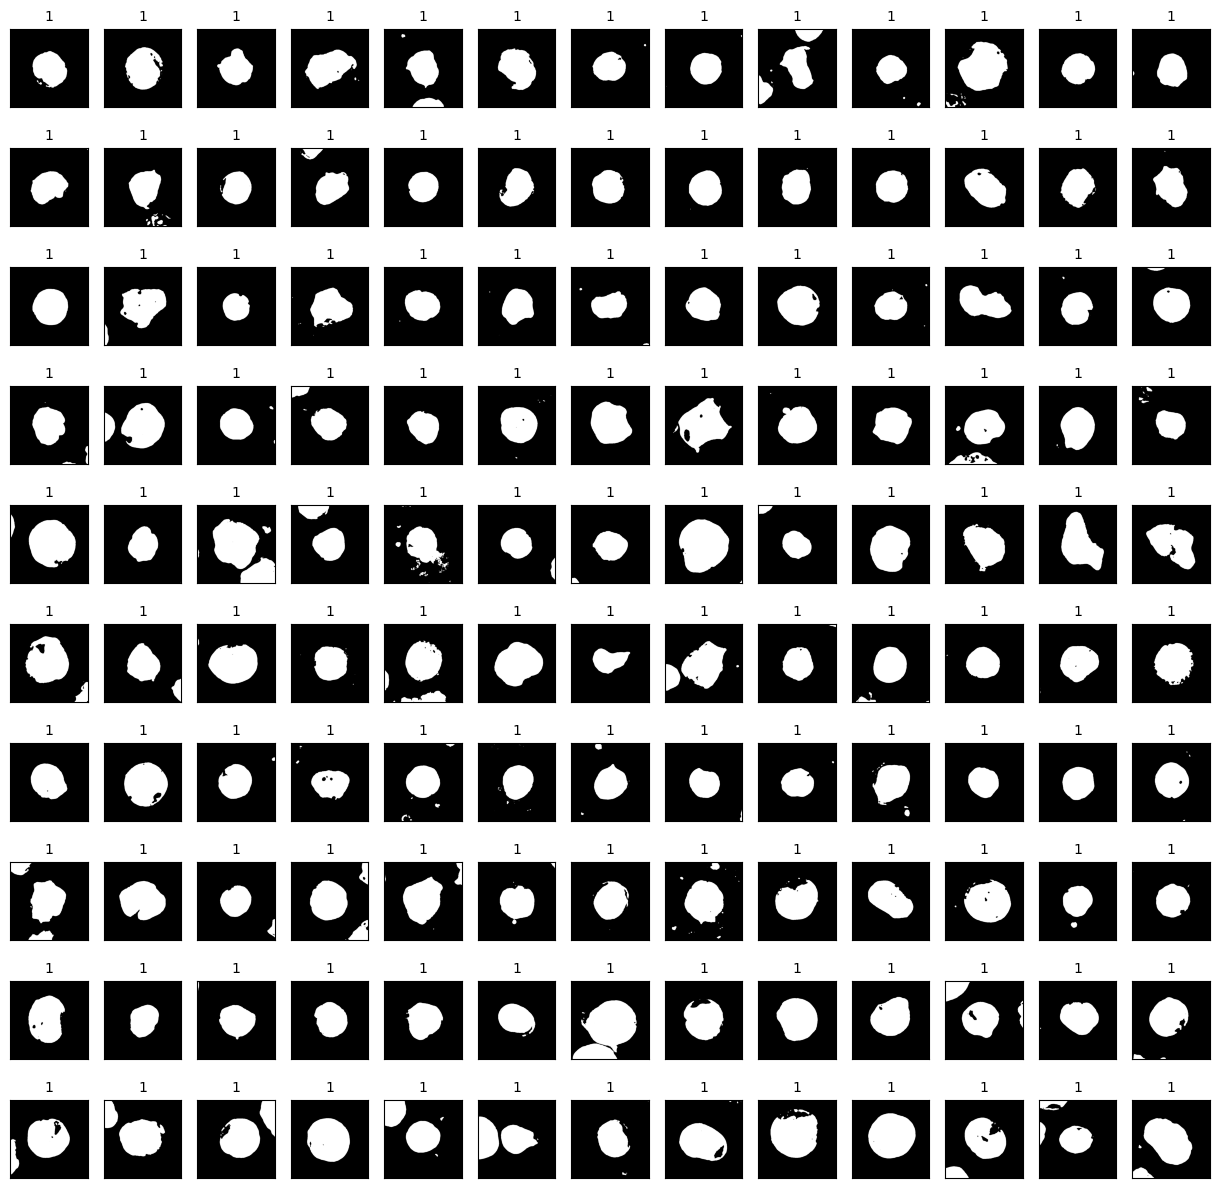

In [48]:
# Create a figure with 10 rows and 13 columns
fig, ax = plt.subplots(10, 13, figsize=(FIG_SIZE , FIG_SIZE))

# Loop through the images and their corresponding numbers
for i, (image, number) in enumerate(zip(ALL_segmented_images, ALL_labels)):
    # Calculate the row and column indices for the current image
    row = i // 13
    col = i % 13

    # Display the image on the corresponding subplot
    ax[row, col].imshow(image, cmap=GRAY)

    # Add the number as text above the image
    ax[row, col].set_title(number, fontsize = FONTSIZE)

    # Remove the ticks on the x and y axes
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

# Adjust the spacing between the subplots
plt.subplots_adjust(WSPACE, HSPACE)

# Display the figure
plt.show()

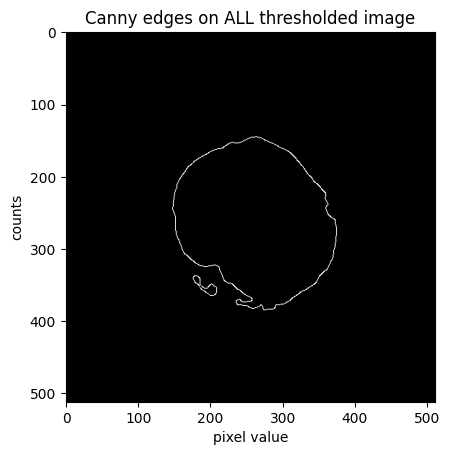

In [49]:
# Display Canny edges for otsu mean thresholded images.
plt.imshow(ALL_edge_images[0], cmap=GRAY)
plt.title("Canny edges on ALL thresholded image")
plt.xlabel("pixel value")
plt.ylabel("counts")
plt.show()

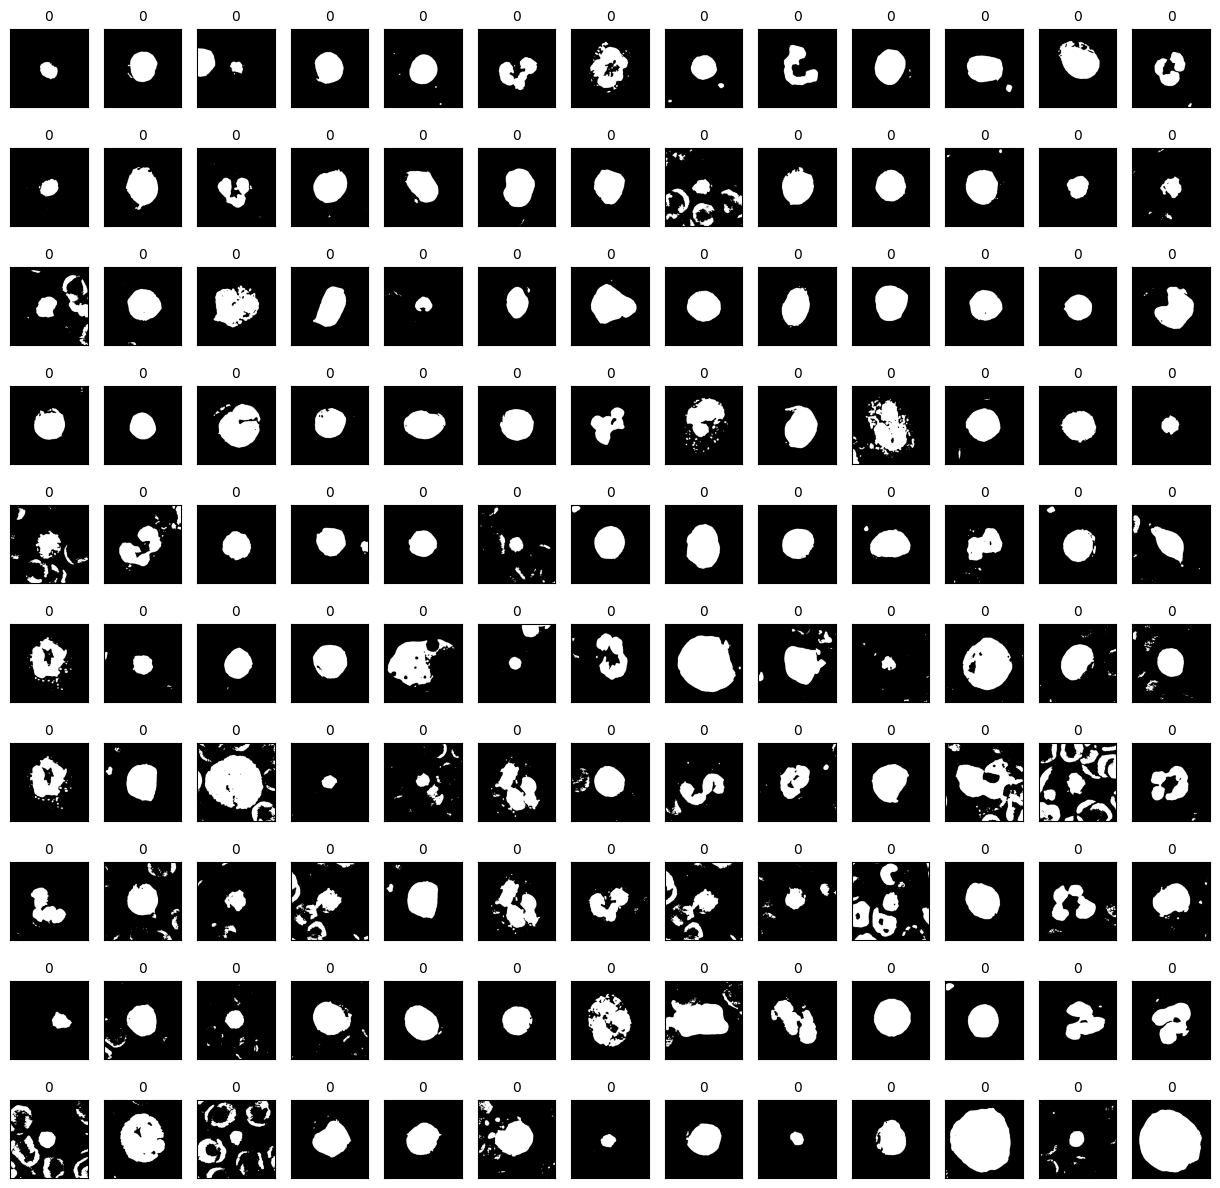

In [50]:
# Create a figure with 10 rows and 13 columns
fig, ax = plt.subplots(10, 13, figsize=(FIG_SIZE, FIG_SIZE))

# Loop through the images and their corresponding numbers
for i, (image, number) in enumerate(zip(NON_ALL_segmented_images, healthy_labels)):
    # Calculate the row and column indices for the current image
    row = i // 13
    col = i % 13

    # Display the image on the corresponding subplot
    ax[row, col].imshow(image, cmap=GRAY)

    # Add the number as text above the image
    ax[row, col].set_title(number, fontsize = FONTSIZE)

    # Remove the ticks on the x and y axes
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

# Adjust the spacing between the subplots
plt.subplots_adjust(WSPACE, HSPACE)

# Display the figure
plt.show()

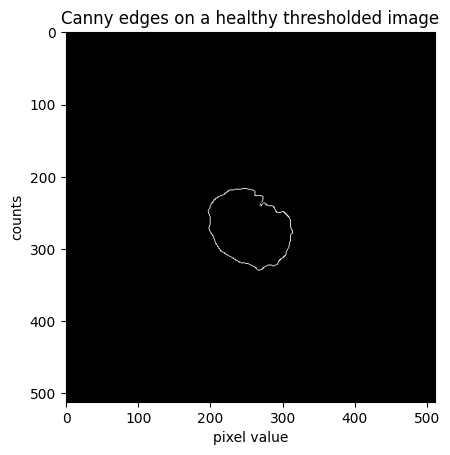

In [51]:
# Display Canny edges for otsu mean thresholded images.
plt.imshow(NON_ALL_edge_images[0], cmap=GRAY)
plt.title("Canny edges on a healthy thresholded image")
plt.xlabel("pixel value")
plt.ylabel("counts")
plt.show()

In [52]:
# Define a list to store the morphologically processed images
ALL_morph_images = []
NON_ALL_morph_images = []

# Taking a matrix of size 5 as the kernel
kernel = np.ones((5, 5), np.uint8)

# Apply opening and eroding operation to each segmented image
for segmented_image in ALL_segmented_images:
    opening_image = cv2.morphologyEx(segmented_image, cv2.MORPH_CLOSE, kernel, iterations=1)
    erode = cv2.erode(opening_image, kernel, iterations = 4)
    ALL_morph_images.append(erode)

# Apply opening and eroding operation to each segmented image
for segmented_image in NON_ALL_segmented_images:
    opening_image = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel, iterations=1)
    erode = cv2.erode(opening_image, kernel, iterations = 5)
    NON_ALL_morph_images.append(erode)

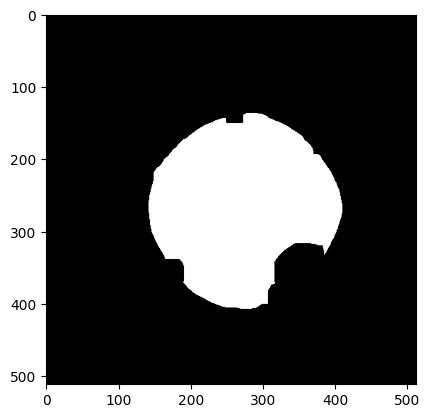

In [53]:
plt.imshow(ALL_morph_images[79], cmap = GRAY)
plt.show()

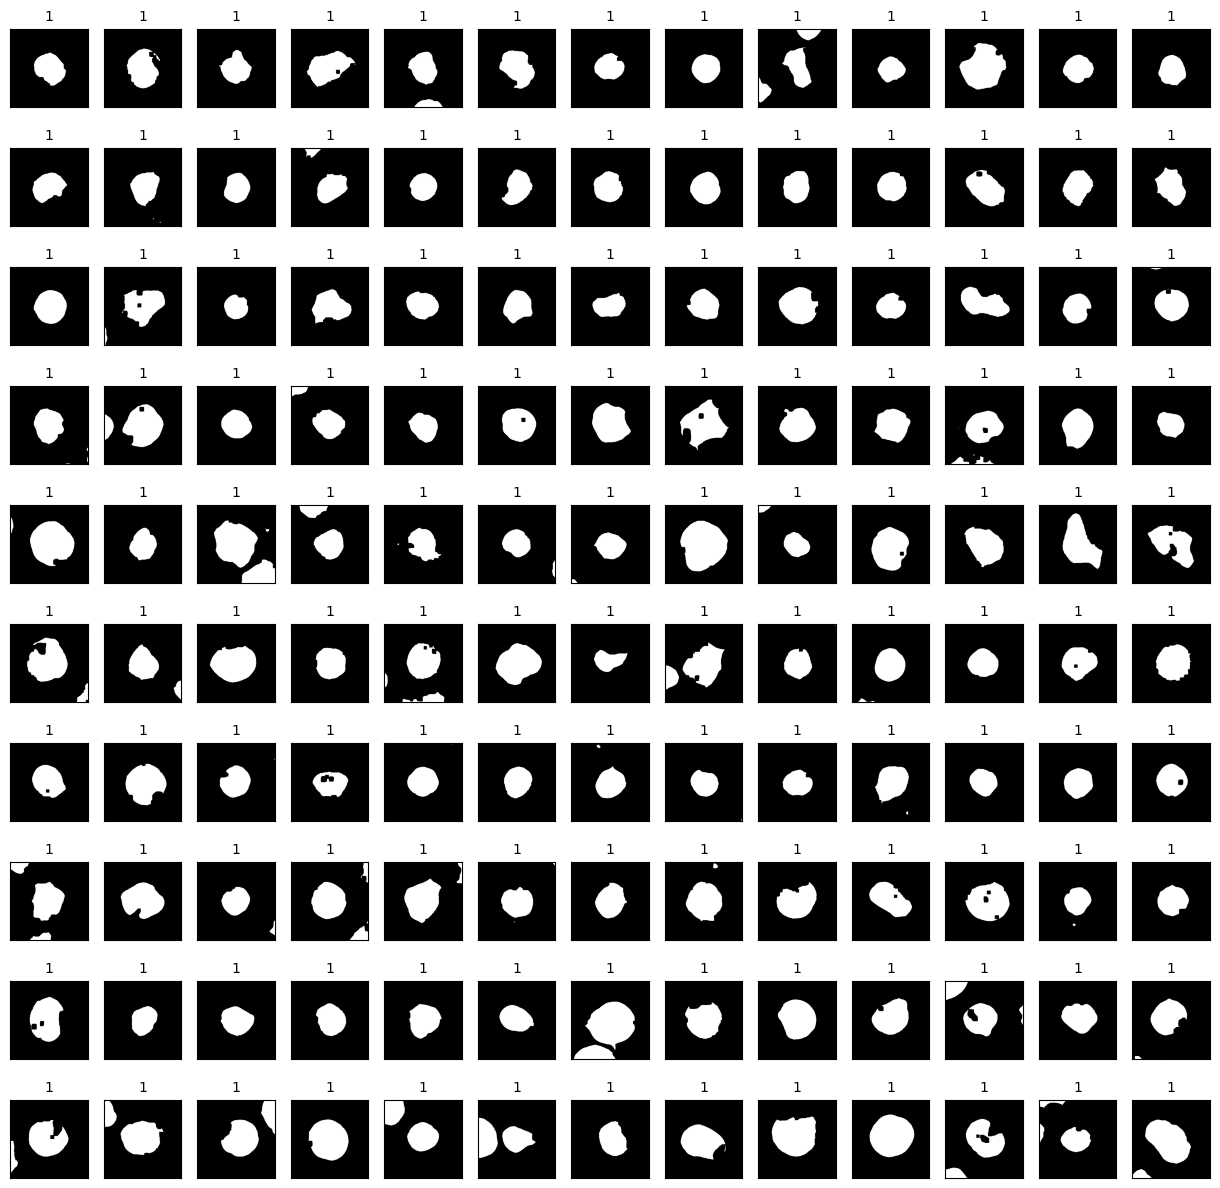

In [54]:
# Create a figure with 10 rows and 13 columns
fig, ax = plt.subplots(10, 13, figsize=(FIG_SIZE, FIG_SIZE))

# Loop through the images and their corresponding numbers
for i, (image, number) in enumerate(zip(ALL_morph_images, ALL_labels)):
    # Calculate the row and column indices for the current image
    row = i // 13
    col = i % 13

    # Display the image on the corresponding subplot
    ax[row, col].imshow(image, cmap=GRAY)

    # Add the number as text above the image
    ax[row, col].set_title(number, fontsize = FONTSIZE)

    # Remove the ticks on the x and y axes
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

# Adjust the spacing between the subplots
plt.subplots_adjust(WSPACE, HSPACE)

# Display the figure
plt.show()

In [55]:
# add 1 pixel white border all around
# top=1, bottom=1, left=1, right=1 mean that 1 pixel-wide border needs to be built
# value = 0 -> black
# top, bottom, left, right; bordertype; the value for the border pixels
# border cleaning

# Create an empty list to store the padded images
ALL_border_cleaned = []
NON_ALL_border_cleaned = []

# Iterate over each image in the list and pad it
for img in ALL_morph_images:
    # Pad the image
    padded_img = cv2.copyMakeBorder(img, TOP, BOTTOM, LEFT, RIGHT, BORDER_TYPE, value=BORDER_VALUE)
    
    # Create a zeros mask 2 pixels larger in each dimension
    height, width = padded_img.shape
    mask = np.zeros([height + 2, width + 2], np.uint8)
    
    # Floodfill the outer white border with black
    img_floodfill = cv2.floodFill(padded_img, mask, seedPoint=SEEDPOINT, newVal=NEWVAL, loDiff=LODIFF, upDiff = UPDIFF, flags= FLAGS)[1]
    
    # Remove the border
    img_floodfill = img_floodfill[1:height-1, 1:width-1]

    # Append the padded image to the list
    ALL_border_cleaned.append(img_floodfill)

# Iterate over each image in the list and pad it
for img in NON_ALL_morph_images:
    # Pad the image
    padded_img = cv2.copyMakeBorder(img, TOP, BOTTOM, LEFT, RIGHT, BORDER_TYPE, value=BORDER_VALUE)
    
    # Create a zeros mask 2 pixels larger in each dimension
    height, width = padded_img.shape
    mask = np.zeros([height + 2, width + 2], np.uint8)
    
    # Floodfill the outer white border with black
    img_floodfill = cv2.floodFill(padded_img, mask, seedPoint = SEEDPOINT, newVal = NEWVAL, loDiff = LODIFF, upDiff = UPDIFF, flags = FLAGS)[1]
    
    # Remove the border
    img_floodfill = img_floodfill[1:height-1, 1:width-1]

    # Append the padded image to the list
    NON_ALL_border_cleaned.append(img_floodfill)

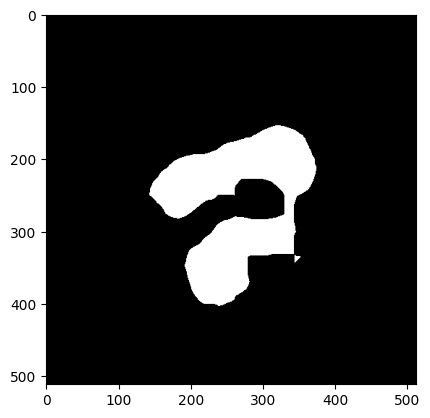

In [56]:
plt.imshow(NON_ALL_border_cleaned[116], cmap = GRAY)
plt.show()

In [57]:
# Define a list to store the flooded images
ALL_flooded_images = []
NON_ALL_flooded_images = []

# Apply floodFill to each opened image in the list
for border_cleaned in ALL_border_cleaned:

    # Copy the thresholded image.
    im_floodfill = border_cleaned.copy()

    # Mask used to flood filling.
    # The size needs to be 2 pixels than the image.
    h, w = border_cleaned.shape[:2]
    mask_fill = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask_fill, (0,0), 255)

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    flooded = border_cleaned | im_floodfill_inv

    # Append the floded image to the list
    ALL_flooded_images.append(flooded)

# Apply floodFill to each opened image in the list
for border_cleaned in NON_ALL_border_cleaned:

    # Copy the thresholded image.
    im_floodfill = border_cleaned.copy()

    # Mask used to flood filling.
    # The size needs to be 2 pixels than the image.
    h, w = border_cleaned.shape[:2]
    mask_fill = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask_fill, (0,0), 255)

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    flooded = border_cleaned | im_floodfill_inv

    # Append the floded image to the list
    NON_ALL_flooded_images.append(flooded)

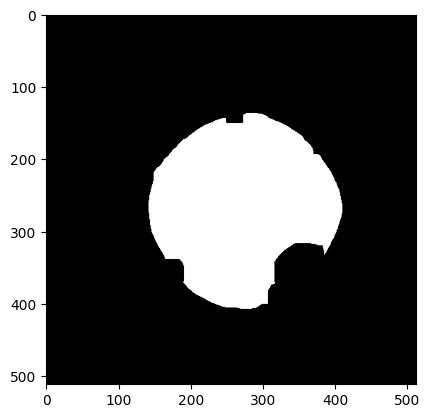

In [58]:
plt.imshow(ALL_flooded_images[79], cmap = GRAY)
plt.show()

In [59]:
# Concatenate the normalized and flooded images for both ALL and healthy cells
normalized_images = np.concatenate((ALL_normalized_images, NON_ALL_normalized_images))
flooded_images = np.concatenate((ALL_flooded_images, NON_ALL_flooded_images))

# Print the length of the concatenated normalized and flooded images for both ALL and healthy cells
print('Length of all normalized images:', len(normalized_images))
print('Length of all flooded images:', len(flooded_images))

# Concatenate the labels for both ALL and healthy cells
labels = np.concatenate((ALL_labels, healthy_labels))
print('Length of all labels:', len(labels))

Length of all normalized images: 260
Length of all flooded images: 260
Length of all labels: 260


In [60]:
# Use the mask to remove the background from the original image
# Create an empty list to store the results
bitwised_images = []

# Iterate over each image in the list and apply the bitwise and operation
for i in range(len(normalized_images)):
    # Create the mask by using the corresponding border_cleaned image
      mask = flooded_images[i]
      
      # Apply the bitwise and operation
      bitwised = cv2.bitwise_and(normalized_images[i], normalized_images[i], mask=mask)
    
      # Append the result to the list
      bitwised_images.append(bitwised)

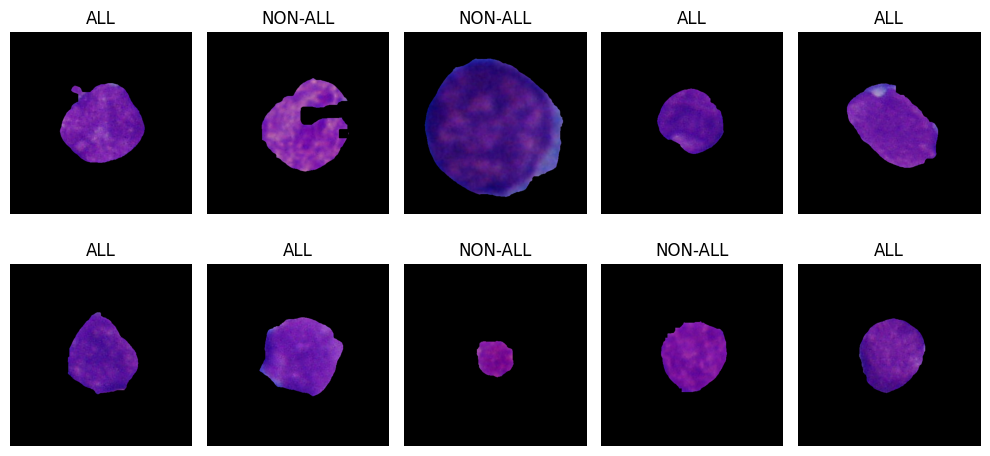

In [61]:
label_names = ['NON-ALL', 'ALL']

# Display 10 random samples
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(bitwised_images))
    ax.imshow(bitwised_images[idx], cmap='gray')
    ax.set_title(label_names[labels[idx]])
    ax.axis('off')
plt.tight_layout()
plt.show()

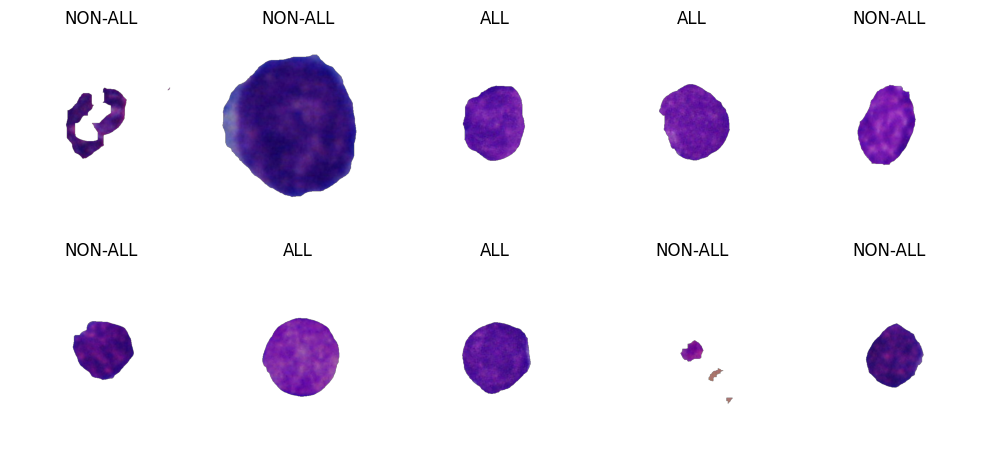

In [62]:
# Create an empty list to store the transparent images
transparent_images = []

# Iterate over each image in the list and apply the transparency mask
for i in range(len(bitwised_images)):
    # Convert the image to grayscale
    gray = cv2.cvtColor(bitwised_images[i], cv2.COLOR_BGR2GRAY)

    # Apply a binary threshold to the grayscale image
    _, alpha = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

    # Split the image into its color channels
    b, g, r = cv2.split(bitwised_images[i])

    # Merge the color channels with the alpha channel to create a transparent image
    rgba = [b, g, r, alpha]
    transparent_img = cv2.merge(rgba, 4)

    # Append the transparent image to the list
    transparent_images.append(transparent_img)



# Display 10 random samples
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(transparent_images))
    ax.imshow(transparent_images[idx], cmap='gray')
    ax.set_title(label_names[labels[idx]])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [63]:
# Create an empty list to store cropped images
cropped_images = []

# Loop through each image in bitwised_images
for i in range(len(bitwised_images)):

    # Convert the image to grayscale
    gray = cv2.cvtColor(bitwised_images[i], cv2.COLOR_BGR2GRAY)
   
    # Find the contours in the image
    contours, hierarchy = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Make a copy of the original image to draw contours on
    original_img_copy = normalized_images[i].copy()

    # If there are any contours found in the image
    if len(contours) > 0:
        # If there is only one contour, draw it and crop the image
        if len(contours) > 0 and len(contours) < 2:
            cv2.drawContours(original_img_copy, contours, contourIdx = CONTOURIDX, color=(255, 255, 0), thickness = THICKNESS)
            x,y,w,h = cv2.boundingRect(contours[0])
            bounded_crop_img = original_img_copy[y:y+h, x:x+w]
            crop_img_not_center = bitwised_images[i][y:y+h, x:x+w]
            if crop_img_not_center.size != 0:
                cropped_images.append(crop_img_not_center)
        
        # If there is more than one contour, find the centermost contour and crop the image
        if len(contours) > 1:
            center = (gray.shape[1] // 2, gray.shape[0] // 2)
            min_dist = float('inf')
            center_contour = None
            for contour in contours:
                dist = cv2.pointPolygonTest(contour, center, True)
                if dist > 0 and dist < min_dist:
                    min_dist = dist
                    center_contour = contour
            if center_contour is not None:
                cv2.drawContours(original_img_copy, [center_contour], contourIdx = CONTOURIDX, color=(255, 255, 0), thickness = THICKNESS)
                x, y, w, h = cv2.boundingRect(center_contour)
                cropped_img_center = bitwised_images[i][y:y+h, x:x+w]
                if cropped_img_center.size != 0:
                    cropped_images.append(cropped_img_center)
            else:
                # If there is no centermost contour, draw the five largest contours and crop the image                            
                contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
                # draw all three contours onto the blank image
                cv2.drawContours(original_img_copy, contours, contourIdx = CONTOURIDX, color=(255, 255, 0), thickness = THICKNESS)
                # get the bounding box of the first contour
                x,y,w,h = cv2.boundingRect(np.vstack(contours))
                # crop the region of interest from the original image and the result image
                cropped_original = bitwised_images[i][y:y+h, x:x+w]
                cropped_result = bitwised_images[i][y:y+h, x:x+w]
                cropped_images.append(cropped_result)
print(len(cropped_images))

260


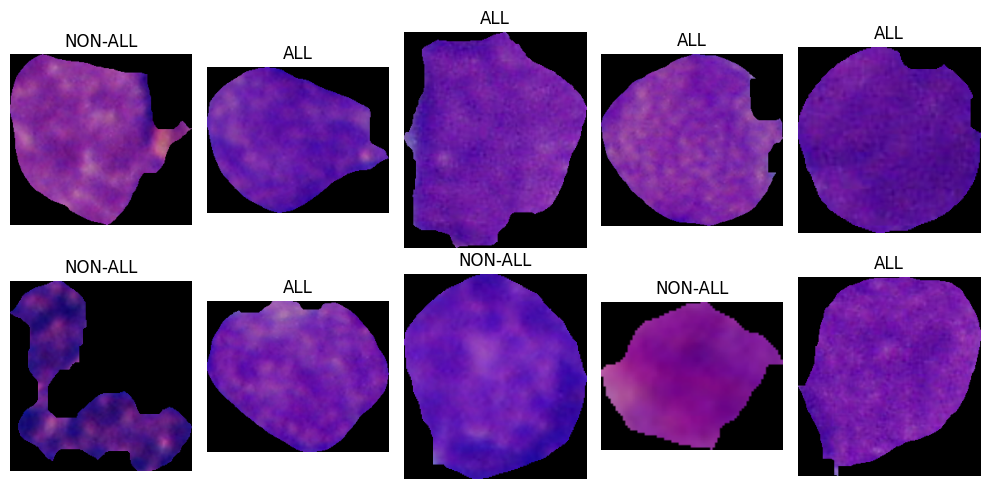

In [64]:
# Display 10 random samples
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(cropped_images))
    ax.imshow(cropped_images[idx], cmap='gray')
    ax.set_title(label_names[labels[idx]])
    ax.axis('off')
plt.tight_layout()
plt.show()

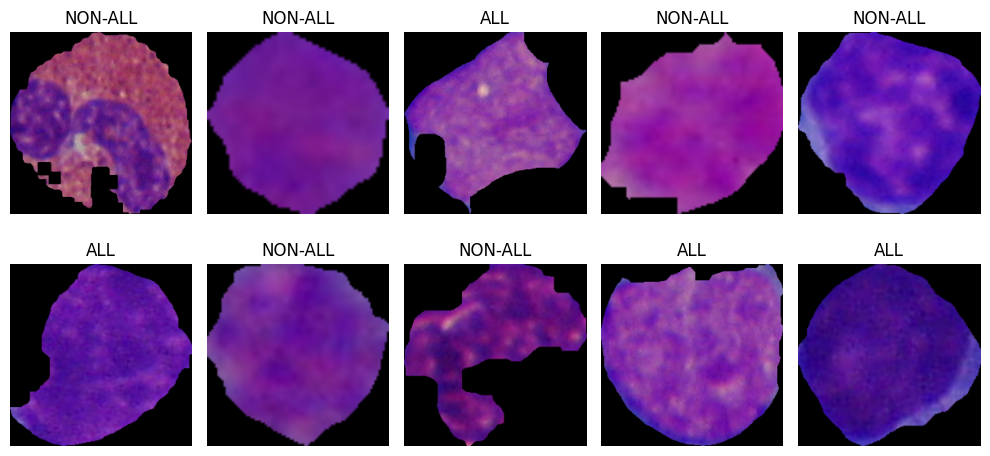

In [65]:
processed_images = []
for image in cropped_images:
    # Split the image into separate color channels
    im_resized = cv2.resize(image, (VIT_IMG_SIZE, VIT_IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    processed_images.append(im_resized)

# Display 10 random samples
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(processed_images))
    ax.imshow(processed_images[idx], cmap=GRAY)
    ax.set_title(label_names[labels[idx]])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [66]:
print('Length of the pre-processed numpy array of images:', len(processed_images))
print('Shape of a sample pre-processed numpy array of images:', processed_images[3].shape)

Length of the pre-processed numpy array of images: 260
Shape of a sample pre-processed numpy array of images: (224, 224, 3)


In [67]:
# Converting the processed images to a numpy array
processed_images = np.array(processed_images)
print(processed_images.shape)

# Combine the labels lists for normal and abnormal cells
original_labels = np.concatenate((ALL_labels, healthy_labels))
print(original_labels.shape)

(260, 224, 224, 3)
(260,)


In [68]:
# Converting the array of labels in class matrix with 23 classes
labels = to_categorical(original_labels)
labels.shape

(260, 2)

In [103]:
original_images = []
for image in normalized_images:
    # Split the image into separate color channels
    im_resized = cv2.resize(image, (VIT_IMG_SIZE, VIT_IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    original_images.append(im_resized)
original_images = np.array(original_images)
print(original_images.shape)

(260, 224, 224, 3)


In [104]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(original_images, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(208, 224, 224, 3)
(52, 224, 224, 3)
(208, 2)
(52, 2)


In [105]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
print(X_train.shape)
print(X_val.shape)

print(y_train.shape)
print(y_val.shape)

(166, 224, 224, 3)
(42, 224, 224, 3)
(166, 2)
(42, 2)


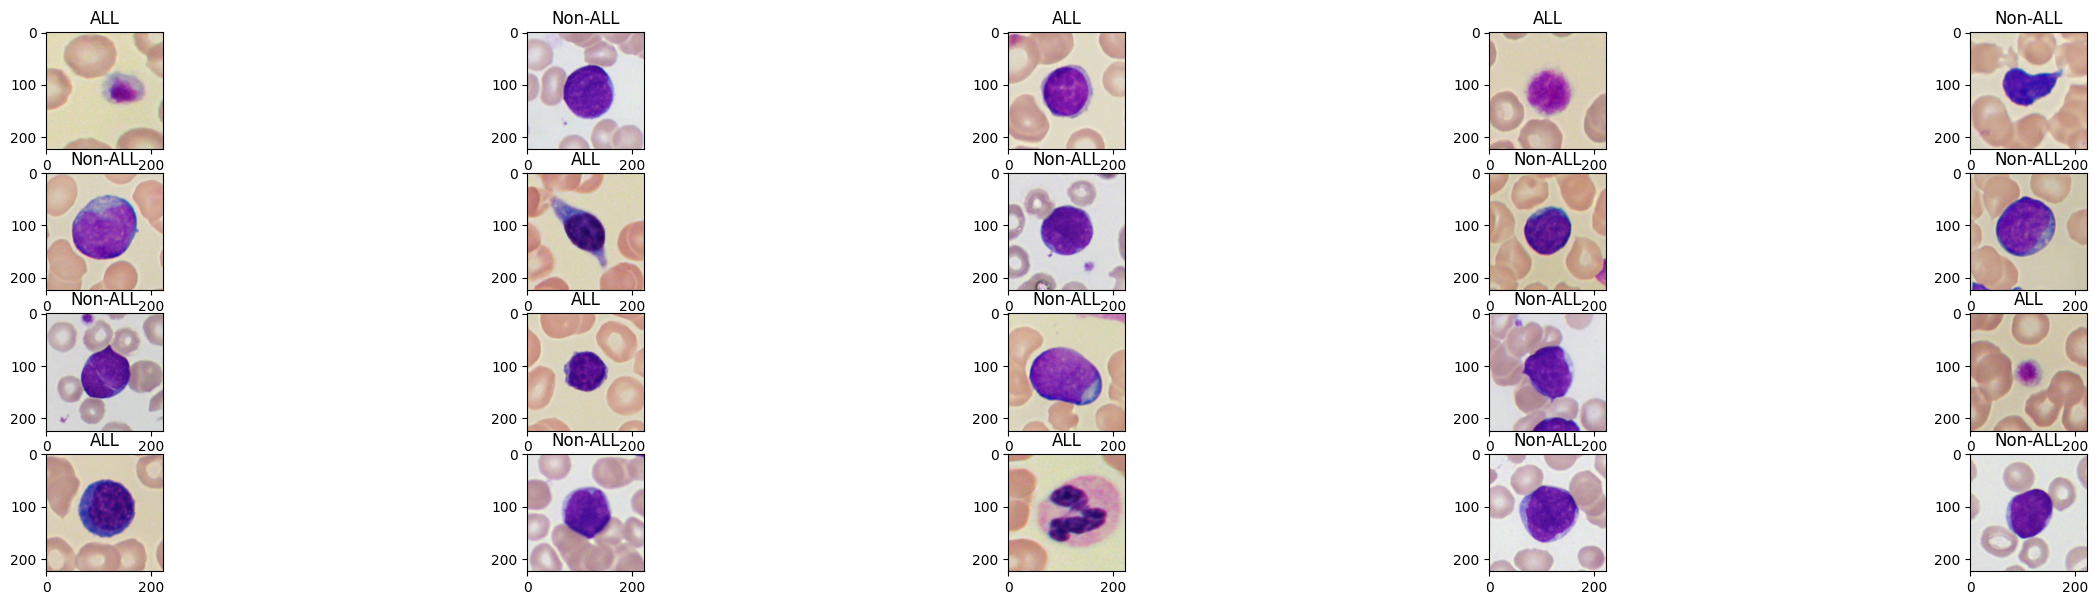

In [106]:
# Get the index of the maximum value in the training labels
y = np.argmax(y_train, axis=-1)

# Create a figure with 4 rows and 5 columns of subplots, with a specified figure size of (30, 7)
f, ax = plt.subplots(4, 5, figsize=(30, 7))

for i in range(0, 20):
    # Plot the i-th image from the X_train array on the i-th subplot in the grid.
    ax[i//5, i%5].imshow(X_train[i])
    if y[i]==1:
        # If the i-th image is labeled as non-ALL, set the subplot title to "Non-ALL"
        ax[i//5, i%5].set_title("Non-ALL")
    else:
        # Set the subplot title to "ALL" for images labeled as ALL.
        ax[i//5, i%5].set_title("ALL")

In [122]:
# Data augmentation implementation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180, 
        width_shift_range=WIDTH_SHIFT_RANGE,      # Randomly shift the image horizontally by up to 10% of the image width
        height_shift_range=HEIGHT_SHIFT_RANGE,     # Randomly shift the image vertically by up to 10% of the image height.
        horizontal_flip=HORIZONTAL_FLIP,       # Randomly flip the image horizontally.
        vertical_flip=VERTICAL_FLIP,         # Randomly flip the image vertically.
        cval=CVAL)                     # The value to fill in the empty space that may appear after rotating or shifting the image

In [123]:
# Creates a data generator for training and returns the augmented images in batches of size 8 during training
train_generator = datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)

In [74]:
# Implementation of the custom layer class for the Shifted Patch Tokenization, which is used in the Vision Transformer model
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=VIT_IMG_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

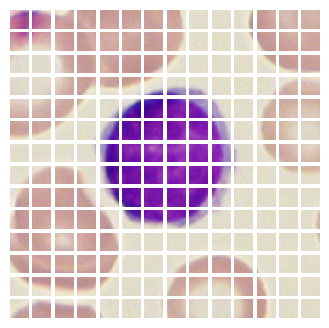

ORIGINAL


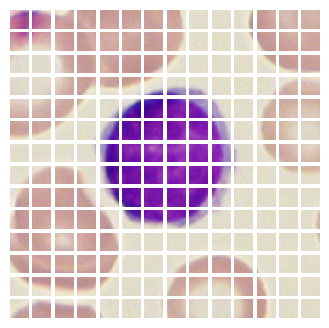

LEFT-UP


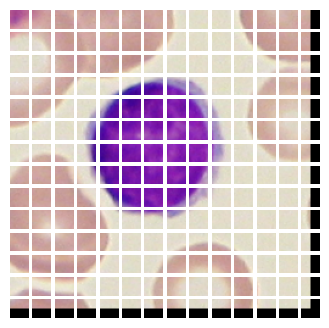

LEFT-DOWN


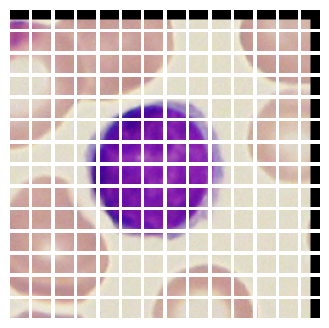

RIGHT-UP


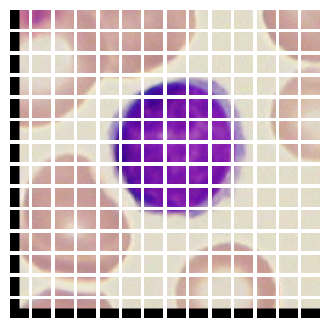

RIGHT-DOWN


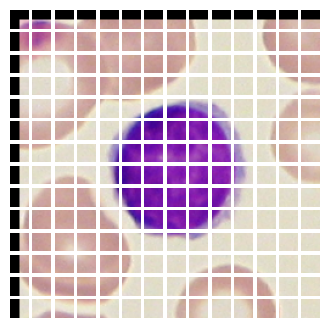

In [78]:
import tensorflow as tf

# Get a random image from the training dataset
# and resize the image
image = X_train[np.random.choice(range(X_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(VIT_IMG_SIZE, VIT_IMG_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()


In [109]:
# Instantiate the ViT model with the specified arguments
vit_model = vit.vit_b16(
    image_size=VIT_IMG_SIZE,             # The input image size is 224 x 224 pixels
    classes=2,                     # The model is trained to classify input images into defined classes
    activation = 'softmax',              # The activation function for the output layer is softmax
    pretrained=True,               # The model is initialized with pre-trained weights from ImageNet
    include_top = False,           # The final fully-connected classification layer is excluded from the model
    pretrained_top = False)     # The pre-trained weights for the final classification layer are not used

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [110]:
# Set the entire ViT model to non-trainable
vit_model.trainable = False

In [111]:
# Get the output of the ViT model and flatten it into a 1D vector
x = Flatten()(vit_model.output)
# Add a fully connected dense layer with 512 neurons and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout layer with a rate of 0.2 to reduce overfitting
x = Dropout(0.2)(x)
# Add another fully connected dense layer with 256 neurons and ReLU activation
x = Dense(256, activation='relu')(x)
# Add a dropout layer with a rate of 0.2 to reduce overfitting
x = Dropout(0.2)(x)
# Add a final fully connected dense layer with 2 neurons and softmax activation for classification
x = Dense(2, activation='softmax')(x)

# Create the final model by specifying the inputs and outputs
model = tf.keras.models.Model(inputs=vit_model.input, outputs=x)

In [ ]:
# Get a random image from the training dataset
image = X_train[np.random.choice(range(X_train.shape[0]))]

# Generate attention map for the image using the trained model
attention_map = visualize.attention_map(model=model, image=image)

# Plot the original image and its corresponding attention map side by side
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [112]:
# Summary of the ViT model architecture including the number of layers, number of parameters, and the output shapes of each layer.
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_5 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [113]:
# Create an instance of the ReduceLROnPlateau class to adjust the learning rate of the optimizer when the validation accuracy plateaus.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',    # The metric to monitor for improvement
                                            patience=PATIENCE,                # The number of epochs to wait before reducing the learning rate when the metric plateaus
                                            verbose=VERBOSE,                 # Progress messages will be printed
                                            factor=FACTOR,                # The factor by which the learning rate will be reduced - halved
                                            min_lr=MIN_LR)            # Learning rate will not be reduced below this value
# Define the LearningRateScheduler callback
lr_scheduler_es = tf.keras.callbacks.EarlyStopping()    

In [124]:
# Define the optimizer with a learning rate of 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

# Compile the model 
model.compile(optimizer = optimizer, loss = LOSS, metrics = ['accuracy'])

In [ ]:
# Train the previously defined model using a generator and a validation set
history = model.fit(train_generator,                                      # A generator that generates batches of augmented training data.
                    validation_data = (X_val, y_val),                     # A tuple containing validation data and labels
                    epochs=EPOCHS,                                        # The number of times to iterate through the entire training dataset.
                    verbose = VERBOSE,                                    # The amount of information to print during training - one line per epoch.
                    steps_per_epoch = X_train.shape[0] // BATCH_SIZE,     # The number of steps per epoch
                    callbacks = [learning_rate_reduction])                # Callback to be applied during training

In [126]:
# Evaluate the model on test data
score = model.evaluate(X_test, y_test)
score

2/2 [==============================] - 1s 257ms/step - loss: 0.3092 - accuracy: 0.8654


[0.30920565128326416, 0.8653846383094788]

In [127]:
# Save the model
model.save('Transformer') 

In [128]:
# Zip and download the trained the ViT model
!zip -r ViT.zip Transformer

  adding: Transformer/ (stored 0%)
  adding: Transformer/fingerprint.pb (stored 0%)
  adding: Transformer/variables/ (stored 0%)
  adding: Transformer/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: Transformer/variables/variables.index (deflated 76%)
  adding: Transformer/saved_model.pb (deflated 92%)
  adding: Transformer/assets/ (stored 0%)
  adding: Transformer/keras_metadata.pb (deflated 96%)


In [130]:
files.download('ViT.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Variables storing the accuracy and loss history of the model during training
training_acc = history.history['accuracy']
training_loss = history.history['loss']

# Plot the training accuracy on the subplot
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(training_acc, label = 'Training Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')


# Plot the training loss on the subplot
plt.subplot(2, 1, 2)
plt.plot(training_loss, label = 'Training Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss')
plt.show()

In [132]:
# Predict the class probabilities for the test set using the trained model
y_pred = model.predict(X_test)

# Extract the predicted class labels from the predicted probabilities 
y_pred = np.argmax(y_pred, axis=1)

# Extract the true class labels from the one-hot encoded form of the test set labels
y_test = np.argmax(y_test, axis=1)

2/2 [==============================] - 4s 249ms/step


In [133]:
# Define confusion matrix with the actual validation labels and predicted labels
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[24,  4],
       [ 3, 21]])

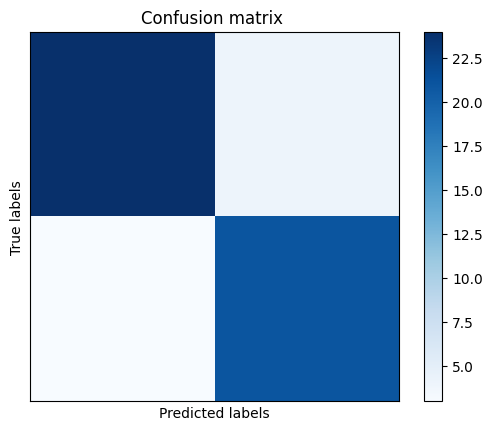

In [134]:
# Plot confusion matrix with the actual validation labels and predicted labels
plt.imshow(matrix, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

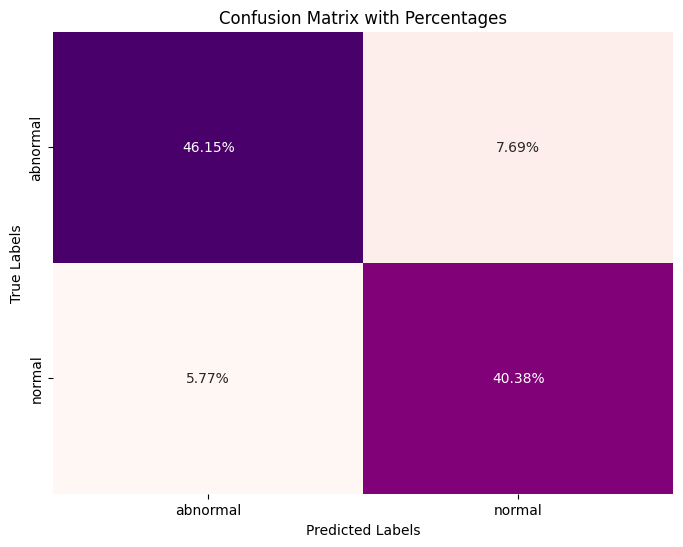

In [135]:
# Calculate the total number of samples
total = np.sum(matrix)

# Calculate the percentages of TP, TN, FP, and FN
TP_percent = matrix[1, 1] / total
TN_percent = matrix[0, 0] / total
FP_percent = matrix[0, 1] / total
FN_percent = matrix[1, 0] / total

# Create a list of the percentages
percentages = [TN_percent, FP_percent, FN_percent, TP_percent]

# Reshape the percentages to match the shape of the confusion matrix
percentages = np.array(percentages).reshape(2, 2)

# Set the figure size
plt.figure(figsize=(8, 6))

# Create a heatmap of the confusion matrix with percentages
sns.heatmap(percentages, annot=True, cmap='RdPu', fmt='.2%', cbar=False,
            yticklabels=['abnormal', 'normal'], xticklabels=['abnormal', 'normal'])

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Percentages')
plt.show()

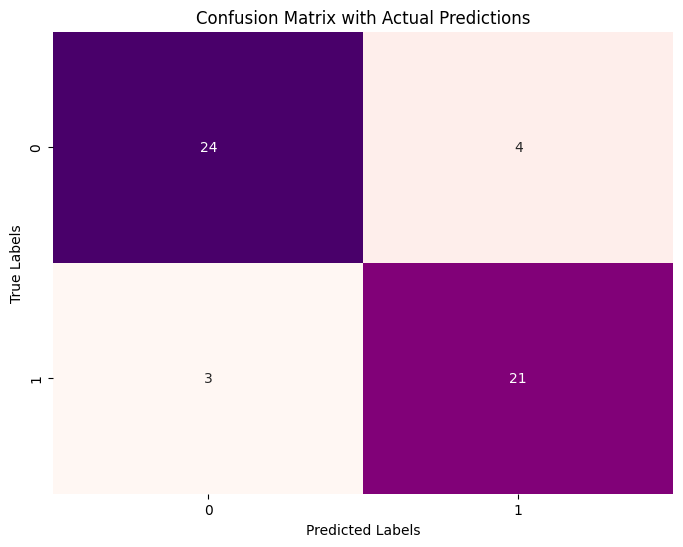

In [136]:
# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap of the confusion matrix with annotations
sns.heatmap(matrix, annot=True, cmap='RdPu', cbar=False)

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Actual Predictions')
plt.show()

In [137]:
# Creating a classification report of precission, recall, f1-score values based on validation labels and predicted validation labels 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        28
           1       0.84      0.88      0.86        24

    accuracy                           0.87        52
   macro avg       0.86      0.87      0.86        52
weighted avg       0.87      0.87      0.87        52



In [138]:
# Print True Positives, True Negatives, False Positives, False Negatives from the confusion matrix
TP = matrix[1, 1]
TN = matrix[0, 0]
FP = matrix[0, 1]
FN = matrix[1, 0]

(TP, TN, FP, FN)

(21, 24, 4, 3)

In [139]:
# Calculate the Sensitivity, Precision, Specificity and F1 score using the confusion matrix
sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

print('Sensitivity:', sensitivity)
print('Precision:', precision)
print('Specificity:', specificity)
print('F1_score:', f1_score)

Sensitivity: 0.875
Precision: 0.84
Specificity: 0.8571428571428571
F1_score: 0.8571428571428572


In [140]:
# Calculate the AUC score using the true labels and the predicted probabilities of the model.
auc_score = roc_auc_score(y_test, y_pred)
print('AUC Score:', auc_score)

AUC Score: 0.8660714285714286


In [141]:
# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

In [142]:
# Multiply the scores by 100 to convert them to percentages and add a percentage sign
sensitivity_percent = '{:.2f}%'.format(sensitivity * 100)
precision_percent = '{:.2f}%'.format(precision * 100)
specificity_percent = '{:.2f}%'.format(specificity * 100)
f1_score_percent = '{:.2f}%'.format(f1_score * 100)
auc_score_percent = '{:.2f}%'.format(auc_score * 100)
accuracy_percent = '{:.2f}%'.format(accuracy * 100)

In [143]:
# Create a dictionary with the scores
scores_dict = {'Accuracy': [accuracy_percent],
               'Sensitivity': [sensitivity_percent],
               'Specificity': [specificity_percent],
               'Precision': [precision_percent],
               'F1 Score': [f1_score_percent],
               'AUC Score': [auc_score_percent]}
# Create a DataFrame from the dictionary
scores_df = pd.DataFrame.from_dict(scores_dict)

# Display the DataFrame
print(scores_df)

  Accuracy Sensitivity Specificity Precision F1 Score AUC Score
0   86.54%      87.50%      85.71%    84.00%   85.71%    86.61%


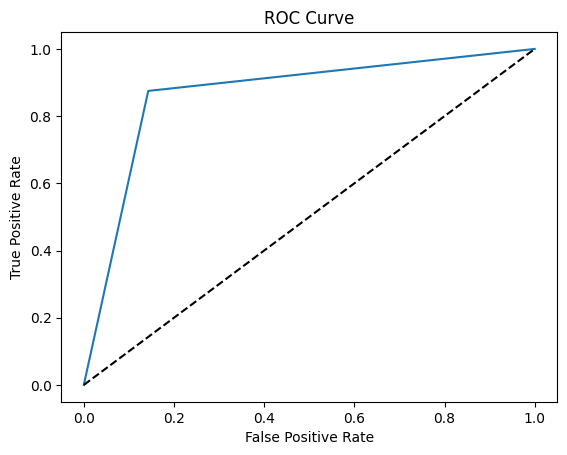

In [144]:
# Calculate the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [145]:
# Creating a classification report of precission, recall, f1-score values based on validation labels and predicted validation labels 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        28
           1       0.84      0.88      0.86        24

    accuracy                           0.87        52
   macro avg       0.86      0.87      0.86        52
weighted avg       0.87      0.87      0.87        52

